In [58]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

simplefilter("ignore")

In [59]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [60]:
data_dir = Path("../Datasets/TS_Course_Data")
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

In [61]:
y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

In [62]:
# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [63]:
# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [64]:
# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

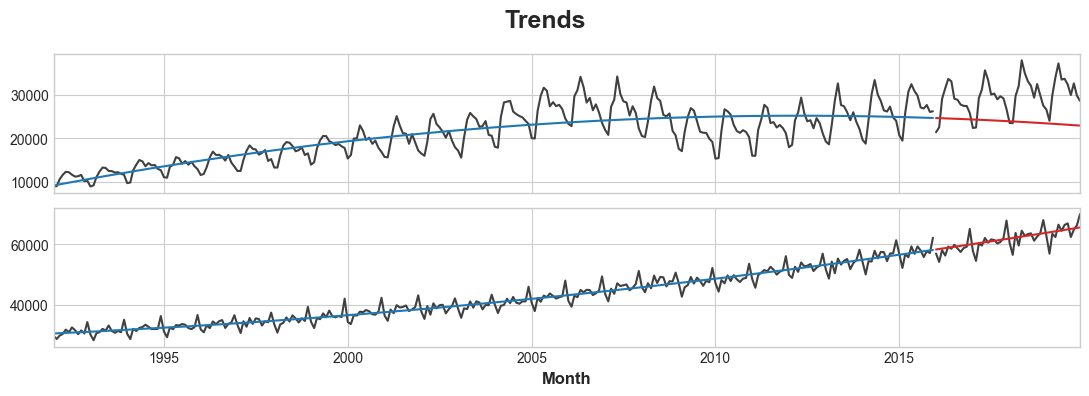

In [65]:
# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [66]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

In [67]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [68]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

<bound method Axes.legend of <Axes: title={'center': 'FoodAndBeverage'}, xlabel='Month'>>

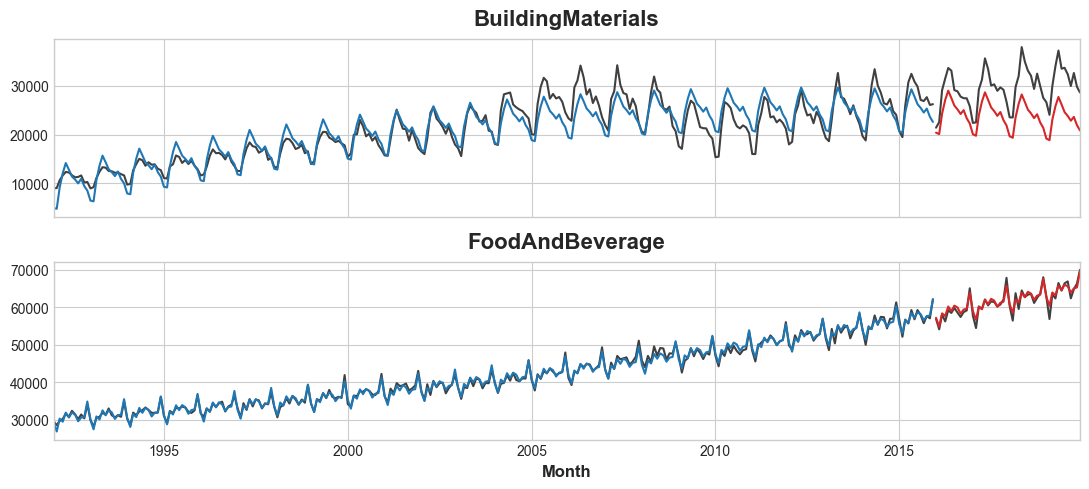

In [70]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])
ax.legend